In [1]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy import integrate as intg
from scipy.optimize import leastsq
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar

### Go to directory

In [2]:
%pwd
%cd ir_data/GL-06-09

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-06-09


### Load Raw Data

In [3]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
#Data.plot(ir_data)

#ir_data

## Auto find prominence

In [8]:
no_reactions = 50

peak_of_interest = 'Peak at 1700 cm-1'
peak_threshold = 0.05

In [18]:
x = ir_data[peak_of_interest]
peaks = find_peaks(x, prominence = peak_threshold)

In [27]:
len(peaks[0])

49

In [114]:
def prominence_finder(var):
    x = ir_data[peak_of_interest]
    peaks = find_peaks(x, prominence = var)
    no_peaks = len(peaks[0])
    abs_diff = abs(no_peaks-no_reactions)
    return abs_diff

In [139]:
prominence_finder(0.0287)

0

In [141]:
mins = minimize_scalar(prominence_finder, method='bounded', bounds=(0,1))
mins
#mins.x

     fun: 0
 message: 'Solution found.'
    nfev: 24
  status: 0
 success: True
       x: 0.028724876348208694

In [143]:
quick_cond = pd.read_excel("Conditions.xlsx")
quick_cond

,Experiment,A,B,C,[A]0,[B]0,[C]0,SPKA,Interval Size,tR (min)
0,Exp1 - R1,A1,B1,C1,1.0,2,0.2,10,10,10
1,Exp1 - R2,A1,B1,C1,1.5,2,0.2,10,5,10
2,Exp1 - R3,A1,B1,C1,1.0,4,0.2,10,10,10
3,Exp1 - R4,A1,B1,C1,1.0,2,0.1,10,10,10
4,Exp1 - R5,A1,B1,C1,1.0,2,0.2,10,10,10


In [149]:
no_reactions = len(quick_cond['Experiment']) * quick_cond['SPKA'].iloc[0]
no_reactions

50

In [6]:
# Final Code
# Choose peak
peak_of_interest = 'Peak at 1700 cm-1'

# Auto find prominence and height to match number of conditions
prominence = peaks.auto_prom(peak_of_interest)
height = peaks.auto_height(peak_of_interest)

print('Prominence threshold =', np.round(prominence, 4))
print('Height threshold =', np.round(height, 4))

Prominence threshold = 0.0287
Height threshold = 0.1957


## Auto find area parameters

In [7]:
quick_cond = pd.read_excel("Conditions.xlsx")
no_reactions = len(quick_cond['Experiment']) * quick_cond['SPKA'].iloc[0]
no_reactions

50

In [10]:
df =[]

for var in range(0, no_reactions * points_per_reaction, points_per_reaction):
    each_r2 = var
    df.append(each_r2)
    
df

[0, 10, 20, 30, 40]

In [9]:
residence_time = 4.5
time_adjust_before = 0
time_adjust_after = 0
no_reactions = 5
points_per_reaction = 10

# Run fitted area
fitted_area = peaks.exp_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

In [11]:
# Calculate the r2 for each reaction
# For loop along each reaction

df = []

for var in range(0, no_reactions * points_per_reaction, points_per_reaction):
    each_r2 = np.corrcoef(fitted_area.iloc[1 + var : 10 + var, 0],fitted_area.iloc[1 + var : 10 + var, 1])[0,1]
    df.append(each_r2)

# Take absolute values of r2
r2 = [abs(ele) for ele in df]

# Sum all the r2 (keep this negative for minimisation)
sum_r2 = -sum(r2)

sum_r2

-4.413552770160059

### Works for just the residence time

In [82]:
# Wrap the above in a function
def area_finder(residence_time):
    
    # Run fitted area
    fitted_area = peaks.fitted_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)
    
    df = []

    for var in range(0, no_reactions * points_per_reaction, points_per_reaction):
        each_r2 = np.corrcoef(fitted_area.iloc[1 + var : 10 + var, 0],fitted_area.iloc[1 + var : 10 + var, 1])[0,1]
        df.append(each_r2)

    # Take absolute values of r2
    r2 = [abs(ele) for ele in df]

    # Sum all the r2 (keep this negative for minimisation)
    sum_r2 = -sum(r2)

    return sum_r2

In [105]:
area_finder(4.51)

-4.368775335526431

In [103]:
lower_bound = 1
upper_bound = 10

mins = minimize_scalar(area_finder, method='bounded', bounds=(lower_bound, upper_bound), options={'xatol' : 1e-5})
mins

     fun: -4.369021583870027
 message: 'Solution found.'
    nfev: 21
  status: 0
 success: True
       x: 6.5363949707776134

In [21]:
lower_bound = 3
upper_bound = 5

mins = minimize_scalar(area_finder, method='bounded', bounds=(lower_bound, upper_bound))
mins

     fun: -4.412516776592019
 message: 'Solution found.'
    nfev: 21
  status: 0
 success: True
       x: 4.514016695539087

### Try for three - Doesn't work, not sure if it'll make a difference

In [56]:
# Wrap the above in a function
def area_finder2(residence_time, time_adjust_before, time_adjust_after):
    
    # Run fitted area
    fitted_area = peaks.exp_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)
    
    df = []

    for var in range(0, no_reactions * points_per_reaction, points_per_reaction):
        each_r2 = np.corrcoef(fitted_area.iloc[1 + var : 10 + var, 0],fitted_area.iloc[1 + var : 10 + var, 1])[0,1]
        df.append(each_r2)

    # Take absolute values of r2
    r2 = [abs(ele) for ele in df]

    # Sum all the r2 (keep this negative for minimisation)
    sum_r2 = -sum(r2)

    return sum_r2

In [57]:
area_finder2(4.5,0.5,0.5)

-4.410069538310998

In [92]:
x0 = tuple(4.5,0,0)

mins = minimize(area_finder2, x0)
mins

TypeError: tuple expected at most 1 argument, got 3

In [97]:
x0 = [4.5,0,0]
x1 = tuple(x0)
x1

(4.5, 0, 0)

### Find the Peaks in the Raw Data

In [5]:
# Instantiate class
peaks = Peaks(ir_data)

# List all the wavelengths observed
#print(ir_data.columns)
print([col for col in ir_data.columns if 'Peak' in col])

['Peak at 1700 cm-1', 'Peak at 1746 cm-1']


IndexError: index 4 is out of bounds for axis 0 with size 4

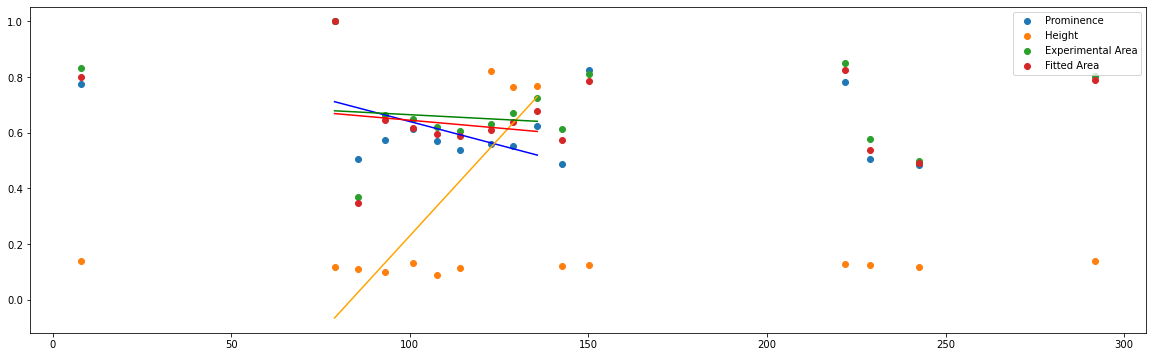

In [86]:
peak_of_interest = 'Peak at 1700 cm-1'
prominence = 0.029
height = 0.193

## PROMINENCE ALL WAVELENGTHS: Determine the peak prominences of every wavelength
#processed_ir_data = peaks.prominence_all(prominence)

## PROMINENCE: Determine the peak prominences of a single wavelength
processed_ir_data = peaks.prominence(prominence, peak_of_interest)

## HEIGHT: # Determine the peak heights of a single wavelength
#processed_ir_data = peaks.height(height, peak_of_interest)

residence_time = 6.5
time_adjust_before = 0
time_adjust_after = 0

## EXP AREA: Determine the experimental areas of a single wavelength
#processed_ir_data = peaks.exp_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## FITTED AREA - SINGLE PEAK: Fit a gaussian to a single peak and determine it's area
#processed_ir_data= peaks.fitted_area_sp(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after, 3)

## FITTED AREA: Determine the fitted areas of a single wavelength
#processed_ir_data = peaks.fitted_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## Compare prominence, height, experimental area, and fitted area
r2, compare = peaks.compare(prominence, height, residence_time, peak_of_interest, 5, 10, time_adjust_before, time_adjust_after)
# NOTE: Areas seem to give the best value when the starting point is exactly on the peak (no baseline before)

## Visualise which peaks have been picked - single peak
peaks.plot(processed_ir_data, peak_of_interest)

#processed_ir_data
#r2

In [50]:
# Trim df (if requried)
#compare = compare.iloc[:-39,:]

# Because R1 t0 is nonsense
#processed_ir_data.iloc[0,1] = 0.46
#processed_ir_data

# Read experimental conditions and add to dataframe

In [51]:
Conditions()
experimental_data = Conditions.read(processed_ir_data)
#experimental_data

Inputs seem good: IR Datapoints =  50 , Number of conditions =  50


### Create the SPKA profiles

In [52]:
spka = SPKA(experimental_data)

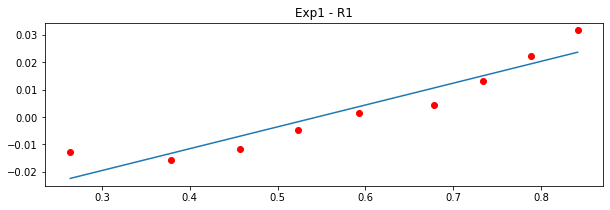

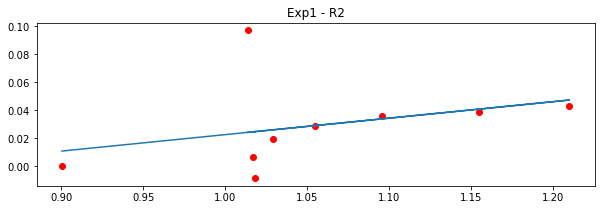

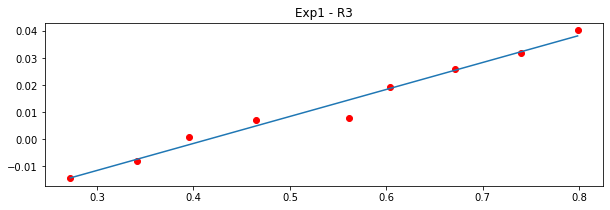

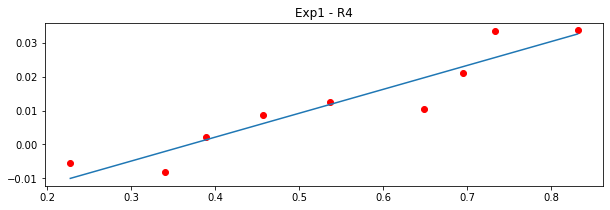

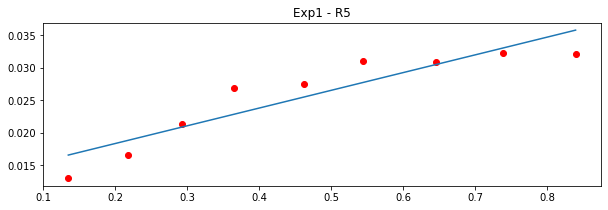

In [53]:
spka_data = spka.spka('[A]0')
spka_data
spka.plot(spka_data)

## To Compare
#r2 = spka.compare('[A]0')
#r2

### Perform RPKA

In [123]:
rpka = RPKA(spka_data)

KeyError: '[Rat]'

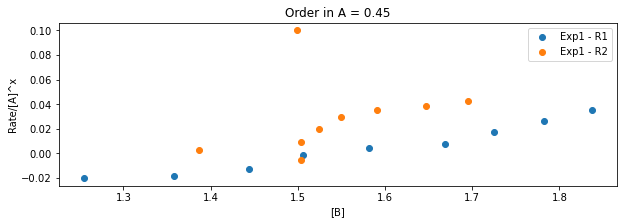

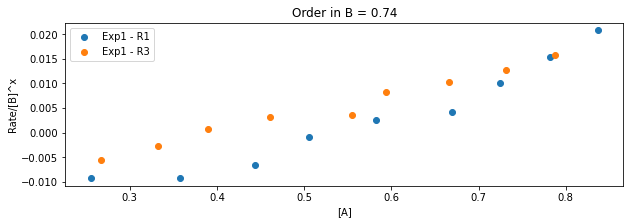

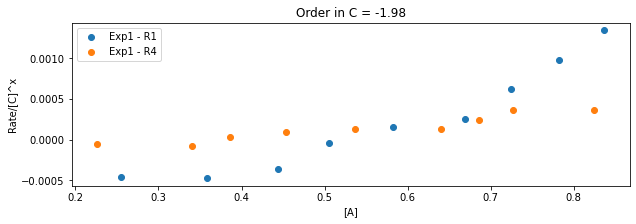

In [124]:
rpka_data = rpka.diff_excess()
#rpka_data

In [54]:
# Set up excelwriter
writer = pd.ExcelWriter('Processed - 1700 - exp area 5-59.xlsx', engine='xlsxwriter')
workbook=writer.book

# Output data
#rpka_data.to_excel(writer, sheet_name='RPKA Data', startrow=0 , startcol=0, index=False)
spka_data.to_excel(writer, sheet_name='SPKA Data', startrow=0 , startcol=0, index=False)
ir_data.to_excel(writer, sheet_name='IR Data', startrow=0 , startcol=0, index=False)
processed_ir_data.to_excel(writer, sheet_name='Processed IR', startrow=0 , startcol=0, index=False)
experimental_data.to_excel(writer, sheet_name='Experimental Data', startrow=0 , startcol=0, index=False)
#conditions.to_excel(writer, sheet_name='Conditions', startrow=0 , startcol=0, index=False)

# Save
writer.save()

# This won't work if the excel file is open